# 📦 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


# 📊 2. Load & Inspect Dataset

In [3]:
# Load dataset
df = pd.read_excel(r"C:\Users\kotho\Downloads\Online Retail.xlsx")
data=df.copy()
# Preview
print(df.shape)
df.head()


(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 🧹 3. Data Cleaning and Preprocessing

In [8]:
# Drop null CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Filter for United Kingdom
df = df[df['Country'] == 'United Kingdom']

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


# 📈 4. Exploratory Data Analysis (EDA) 
# 🏗️ 5. Feature Engineering


In [15]:
# Snapshot date (just after last purchase date)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create customer-level summary
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days, 'nunique'],
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})

# Rename columns
customer_df.columns = ['Recency', 'Frequency', 'NumInvoices', 'TotalQuantity', 'TotalSpend']
customer_df['AOV'] = customer_df['TotalSpend'] / customer_df['NumInvoices']
customer_df['CLTV'] = customer_df['TotalSpend']


In [16]:
# Top 5 spending customers
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head()
print("Top 5 Customers by Spend:\n", top_customers)


Top 5 Customers by Spend:
 CustomerID
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
17511.0     91062.38
16029.0     81024.84
Name: TotalPrice, dtype: float64


C:\Users\kotho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


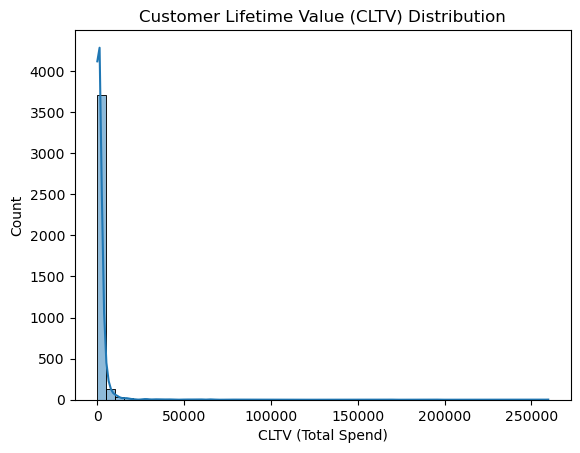

In [17]:
sns.histplot(customer_df['CLTV'], bins=50, kde=True)
plt.title("Customer Lifetime Value (CLTV) Distribution")
plt.xlabel("CLTV (Total Spend)")
plt.show()


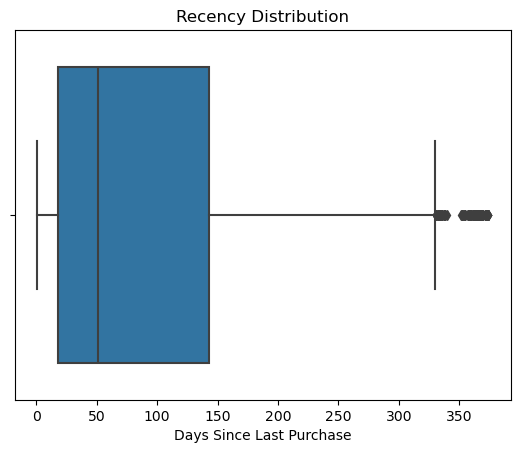

In [18]:
sns.boxplot(x=customer_df['Recency'])
plt.title("Recency Distribution")
plt.xlabel("Days Since Last Purchase")
plt.show()


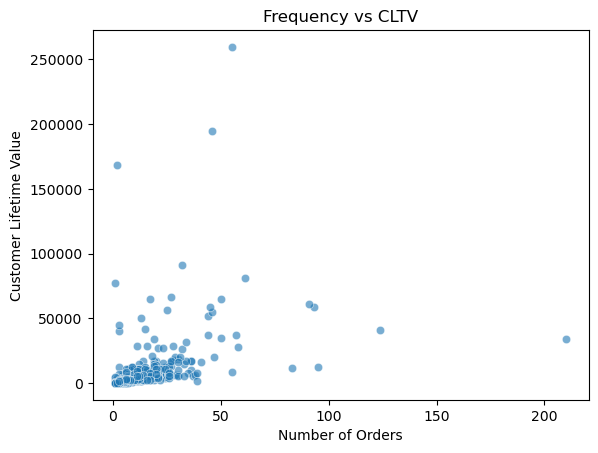

In [22]:
sns.scatterplot(data=customer_df, x='Frequency', y='CLTV', alpha=0.6)
plt.title("Frequency vs CLTV")
plt.xlabel("Number of Orders")
plt.ylabel("Customer Lifetime Value")
plt.show()


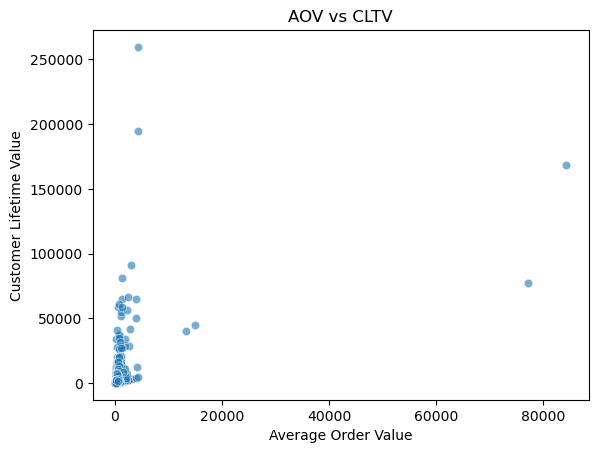

In [25]:
sns.scatterplot(data=customer_df, x='AOV', y='CLTV', alpha=0.6)
plt.title("AOV vs CLTV")
plt.xlabel("Average Order Value")
plt.ylabel("Customer Lifetime Value")
plt.show()


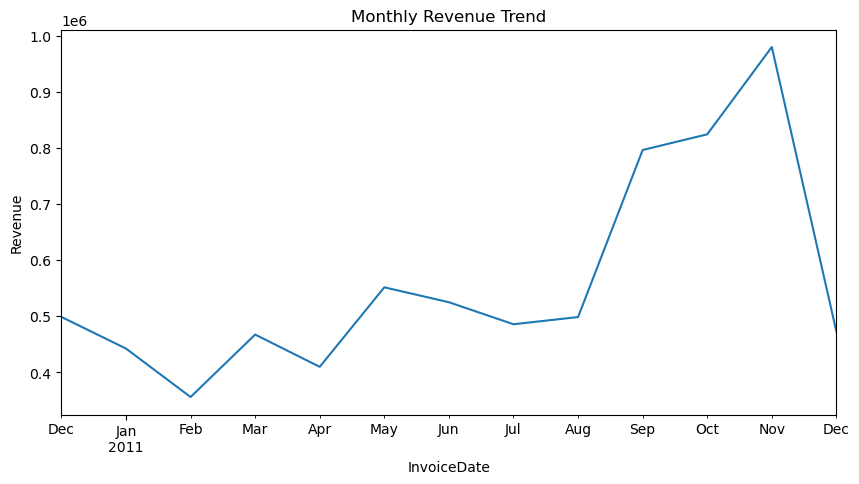

In [27]:
df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().plot(figsize=(10, 5), title='Monthly Revenue Trend')
plt.ylabel("Revenue")
plt.show()


# 🤖 6. Model Building

In [33]:
# Features and Target
features = ['Recency', 'Frequency', 'NumInvoices', 'TotalQuantity', 'AOV']
X = customer_df[features]
y = customer_df['CLTV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

# 📉 7. Model Evaluation

In [36]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 305.83
RMSE: 2695.84


# 🧩 8. CLTV Segmentation

In [38]:
customer_df['Predicted_CLTV'] = model.predict(customer_df[features])
customer_df['Segment'] = pd.qcut(customer_df['Predicted_CLTV'], 4, labels=['Low', 'Medium', 'High', 'Top'])

# View sample
customer_df[['Recency', 'Frequency', 'AOV', 'Predicted_CLTV', 'Segment']].head()


,Recency,Frequency,AOV,Predicted_CLTV,Segment
CustomerID,,,,,
12346.0,326,1,77183.600000,76499.445312,Top
12747.0,2,11,381.455455,4035.476807,Top
12748.0,1,210,161.338421,34051.445312,Top
12749.0,4,5,818.176000,3563.579102,Top
12820.0,3,4,235.585000,949.577209,High


# Final Results

C:\Users\kotho\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


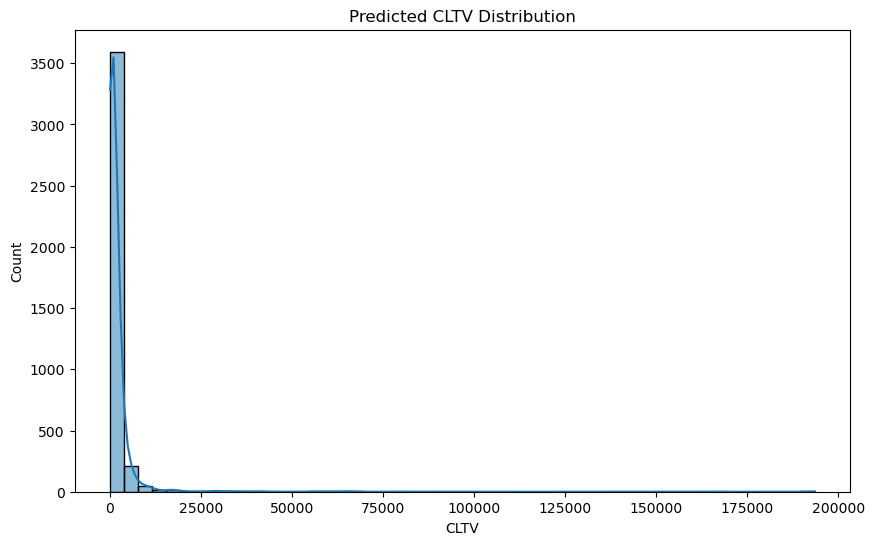

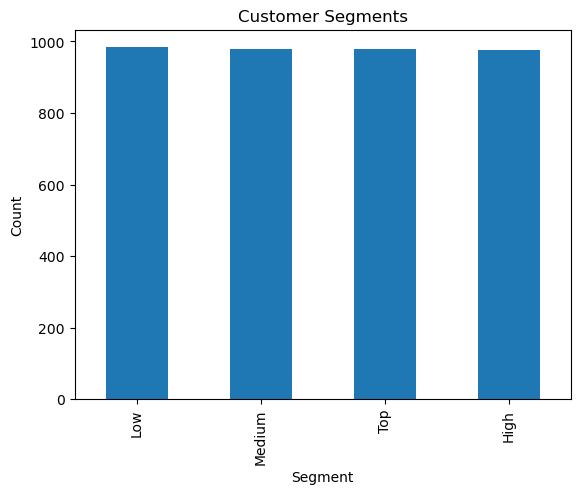

In [41]:
# CLTV distribution
plt.figure(figsize=(10, 6))
sns.histplot(customer_df['Predicted_CLTV'], bins=50, kde=True)
plt.title("Predicted CLTV Distribution")
plt.xlabel("CLTV")
plt.show()

# Segment counts
customer_df['Segment'].value_counts().plot(kind='bar', title='Customer Segments')
plt.ylabel("Count")
plt.show()


# 💾 10. Save Output

In [44]:
customer_df.to_csv(r"C:\Users\kotho\Downloads\Final_CLTV_Prediction.csv")